# CFRM 421 Final Proejct - Terence Chiu

# Introduction

What is the goal of your project?

• What is the data that you are using? What is the original data source if known?

• What does an instance in your data represent (e.g. a person, a transaction, etc.)? How many
instances are there?

• What is the target variable you are trying to predict?

• What are the features used to predict it? Give a few examples of the features.

• Provide any additional relevant information about your data if known (e.g. what is the time
period, what place is it collected from, etc.

# Problem Setup

In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# Algorithms

DNN  
Inputs:
- Weekly Import
- Weekly Production
- Weekly Supply
- Crude Oil Futures Price 1-2 minutes before release  

Outputs (predict): 
- Futures Price 1-2 minutes after release

In [19]:
class DNN:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate
        self.model = None
        self.feature_weights = None
        self.scaler = None

    def build_model(self, input_shape=(7,)):
        """
        Build the model architecture
        input_shape: (7,) for 4 price features + 3 weekly features
        """
        self.reset_session()
        # Input layer
        inputs = Input(shape=input_shape)
        
        # Split input into price and weekly features
        price_features = inputs[:, :4]  # First 4 features are price features
        weekly_features = inputs[:, 4:]  # Last 3 features are weekly data
        
        # Dense layers for price features
        price_dense = Dense(16, activation='relu')(price_features)
        price_dense = Dropout(0.2)(price_dense)
        
        # Dense layers for weekly features
        weekly_dense = Dense(16, activation='relu')(weekly_features)
        weekly_dense = Dropout(0.2)(weekly_dense)
        
        # Combine price and weekly features
        combined = Concatenate()([price_dense, weekly_dense])
        
        # Output layers
        dense1 = Dense(32, activation='relu')(combined)
        dense1 = Dropout(0.2)(dense1)
        outputs = Dense(1)(dense1)
        
        # Create model
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                     loss='mse',
                     metrics=['mae'])
        
        return model

    def reset_session(self, seed=42):
        tf.random.set_seed(seed)
        np.random.seed(seed)
        tf.keras.backend.clear_session()

    def train(self, X, y, validation_split=0.2, epochs=100, batch_size=32):
        """
        Train the model
        X: input features (4 price features + 3 weekly features)
        y: target values (single value)
        """
        if self.model is None:
            self.model = self.build_model()
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     restore_best_weights=True)
        
        # Train the model
        history = self.model.fit(X, y,
                               validation_split=validation_split,
                               epochs=epochs,
                               batch_size=batch_size,
                               callbacks=[early_stopping],
                               verbose=1)
        
        return self.model, history

    def predict(self, model, X):
        """
        Make predictions
        X: input features (4 price features + 3 weekly features)
        """
        return model.predict(X)

    def save(self, filepath):
        """
        Save the model
        """
        if self.model is not None:
            self.model.save(filepath)
        else:
            raise ValueError("No model to save. Train the model first.")

    def prepare_data(self, price_features, weekly_production, weekly_import, weekly_supply):
        """
        Prepare input data with proper feature ordering
        price_features: array of shape (n_samples, 4) containing selected price features
        weekly_production, weekly_import, weekly_supply: arrays of shape (n_samples,)
        """
        # Stack weekly features
        weekly_features = np.column_stack([
            weekly_production,
            weekly_import,
            weekly_supply
        ])
        # Combine price and weekly features
        X = np.column_stack([price_features, weekly_features])
        return X 

Using the DNN

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7465 - mae: 0.7522 - val_loss: 0.3522 - val_mae: 0.4766
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3067 - mae: 0.4314 - val_loss: 0.0767 - val_mae: 0.2146
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2182 - mae: 0.3533 - val_loss: 0.0291 - val_mae: 0.1338
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1474 - mae: 0.2943 - val_loss: 0.0244 - val_mae: 0.1282
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1480 - mae: 0.2814 - val_loss: 0.0272 - val_mae: 0.1260
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 - mae: 0.2763 - val_loss: 0.0149 - val_mae: 0.1002
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1316 - mae: 0.2721 - val_loss: 0.0111 - val_mae: 0.0759
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 - mae: 0.2772 - val_loss: 0.0094 - val_mae: 0.0710
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.101

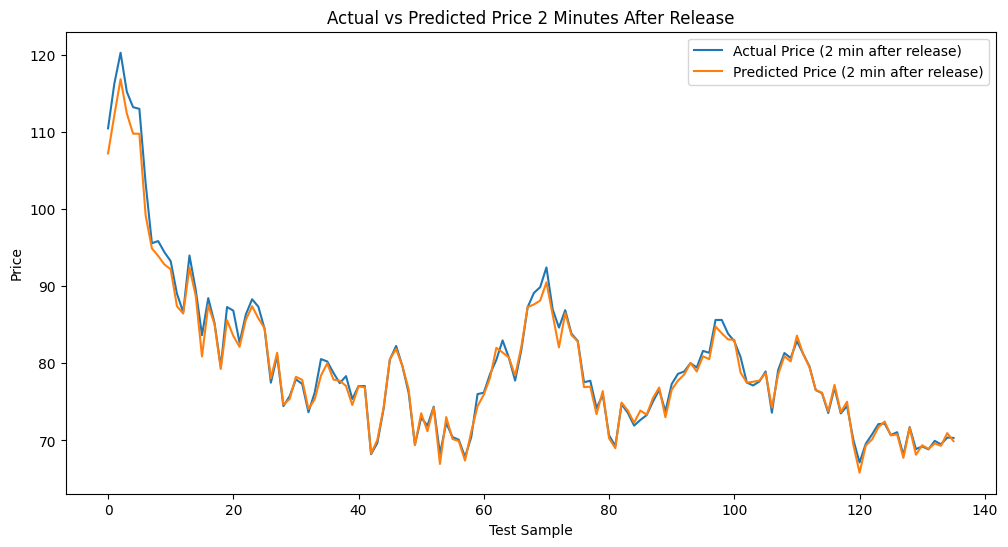

In [21]:
def convert_to_number(value):
    """Convert string with M suffix to float"""
    if isinstance(value, str):
        return float(value.replace('M', '')) * 1000000
    return value

def load_and_prepare_data():
    # Load data
    prod_weekly = pd.read_csv('domestic_prod.csv', encoding='latin1')
    net_import_weekly = pd.read_csv('net_import.csv', encoding='latin1')
    supply_weekly = pd.read_csv('InvestingcomEIA.csv', encoding='latin1')
    price_wide = pd.read_csv('price_window_valid_wide.csv', encoding='latin1')
    
    
    # Convert dates
    prod_weekly['ï»¿Date'] = pd.to_datetime(prod_weekly['ï»¿Date'], format='%b %d, %Y', errors='coerce')
    net_import_weekly['ï»¿Date'] = pd.to_datetime(net_import_weekly['ï»¿Date'], format='%b %d, %Y', errors='coerce')
    supply_weekly['Release Date'] = pd.to_datetime(supply_weekly['Release Date'], format='%d-%b-%y', errors='coerce')
    price_wide['Release_Datetime'] = pd.to_datetime(price_wide['Release_Datetime'], errors='coerce')
    
    # Get timezone from price_wide's Release_Datetime
    tz = price_wide['Release_Datetime'].dt.tz
    
    # Convert naive timestamps to match price_wide's timezone
    prod_weekly['ï»¿Date'] = prod_weekly['ï»¿Date'].dt.tz_localize(tz)
    net_import_weekly['ï»¿Date'] = net_import_weekly['ï»¿Date'].dt.tz_localize(tz)
    supply_weekly['Release Date'] = supply_weekly['Release Date'].dt.tz_localize(tz)
    
    # Convert supply values from strings with M suffix to numbers
    supply_weekly['Actual'] = supply_weekly['Actual'].apply(convert_to_number)
    supply_weekly['Forecast'] = supply_weekly['Forecast'].apply(convert_to_number)
    supply_weekly['Previous'] = supply_weekly['Previous'].apply(convert_to_number)
    
    # Filter date range for weekly data and price_wide
    start_date = pd.to_datetime('2012-01-01').tz_localize(tz)
    end_date = pd.to_datetime('2025-01-01').tz_localize(tz)
    prod_weekly = prod_weekly[(prod_weekly['ï»¿Date'] >= start_date) & (prod_weekly['ï»¿Date'] < end_date)]
    net_import_weekly = net_import_weekly[(net_import_weekly['ï»¿Date'] >= start_date) & (net_import_weekly['ï»¿Date'] < end_date)]
    supply_weekly = supply_weekly[(supply_weekly['Release Date'] >= start_date) & (supply_weekly['Release Date'] < end_date)]
    price_wide = price_wide[(price_wide['Release_Datetime'] >= start_date) & (price_wide['Release_Datetime'] < end_date)]
    
    return prod_weekly, net_import_weekly, supply_weekly, price_wide

def prepare_supervised_data_wide(price_wide, weekly_production, weekly_import, weekly_supply, scaler, target_scaler, prod_weekly, net_import_weekly, supply_weekly):
    X = []
    y = []

    # Convert weekly data date columns to datetime
    prod_weekly['ï»¿Date'] = pd.to_datetime(prod_weekly['ï»¿Date'])
    net_import_weekly['ï»¿Date'] = pd.to_datetime(net_import_weekly['ï»¿Date'])
    supply_weekly['Release Date'] = pd.to_datetime(supply_weekly['Release Date'])
    price_wide['Release_Datetime'] = pd.to_datetime(price_wide['Release_Datetime'])

    for idx, row in price_wide.iterrows():
        # Extract price features
        price_features = [
            row['Close_t-60'],
            row['Close_t-40'],
            row['Close_t-20'],
            row['Close_t0']
        ]
        price_features_scaled = scaler.transform(np.array(price_features).reshape(-1, 1)).flatten()

        # Target: price 2 minutes after release
        target_price = row['Close_t2']
        target_price_scaled = target_scaler.transform([[target_price]])[0, 0]

        # Match weekly features by date
        report_date = row['Release_Datetime'].date()
        production_value = weekly_production[prod_weekly['ï»¿Date'].dt.date == report_date]
        import_value = weekly_import[net_import_weekly['ï»¿Date'].dt.date == report_date]
        supply_value = weekly_supply[supply_weekly['Release Date'].dt.date == report_date]
        production_value = production_value[0] if len(production_value) > 0 else 0
        import_value = import_value[0] if len(import_value) > 0 else 0
        supply_value = supply_value[0] if len(supply_value) > 0 else 0

        X.append(np.concatenate([price_features_scaled, [production_value, import_value, supply_value]]))
        y.append(target_price_scaled)
    return np.array(X), np.array(y)

def plot_predictions(predictions, actuals, scaler, save_path='actual_vs_predicted_2min.png'):
    """
    Plot predictions vs actual values (unscaled) and print MAE.
    """
    # Inverse transform only the predictions
    predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_unscaled = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()  # Already in original scale

    # Calculate MAE on unscaled data
    mae = mean_absolute_error(actuals_unscaled, predictions_unscaled)
    print(f"Test MAE (unscaled): {mae:.2f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_unscaled, label='Actual Price (2 min after release)')
    plt.plot(predictions_unscaled, label='Predicted Price (2 min after release)')
    plt.title('Actual vs Predicted Price 2 Minutes After Release')
    plt.xlabel('Test Sample')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig(save_path)
    plt.show()

def main():
    # Load and prepare data
    prod_weekly, net_import_weekly, supply_weekly, price_wide = load_and_prepare_data()
    
    # For features (X): all Close prices used for features
    all_feature_prices = []
    all_target_prices = []
    for idx, row in price_wide.iterrows():
        all_feature_prices.extend([row['Close_t-60'], row['Close_t-40'], row['Close_t-20'], row['Close_t0']])
        all_target_prices.append(row['Close_t2'])
    all_feature_prices = np.array(all_feature_prices)
    all_target_prices = np.array(all_target_prices)

    # For features (X)
    feature_scaler = StandardScaler()
    # For target (y)
    target_scaler = StandardScaler()

    # Fit feature scaler on all price data used for features
    feature_scaler.fit(all_feature_prices.reshape(-1, 1))
    # Fit target scaler on all target prices
    target_scaler.fit(all_target_prices.reshape(-1, 1))

    # Scale weekly features
    weekly_features = np.concatenate([
        prod_weekly['US Weekly Production'].values,
        net_import_weekly['Weekly Net Import'].values,
        supply_weekly['Actual'].values
    ]).reshape(-1, 1)
    weekly_scaler = StandardScaler()
    weekly_scaler.fit(weekly_features)
    
    weekly_production_scaled = weekly_scaler.transform(prod_weekly['US Weekly Production'].values.reshape(-1, 1)).flatten()
    weekly_import_scaled = weekly_scaler.transform(net_import_weekly['Weekly Net Import'].values.reshape(-1, 1)).flatten()
    weekly_supply_scaled = weekly_scaler.transform(supply_weekly['Actual'].values.reshape(-1, 1)).flatten()
    
    # Prepare supervised data
    X, y = prepare_supervised_data_wide(
        price_wide, 
        weekly_production_scaled, 
        weekly_import_scaled,
        weekly_supply_scaled,
        feature_scaler,
        target_scaler,
        prod_weekly,
        net_import_weekly,
        supply_weekly
    )
    # Time-based 80/20 split
    n = len(X)
    split_idx = int(n * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
 
    # Initialize model
    model = DNN()
    
    # Train model
    trained_model, history = model.train(X_train, y_train)
    
    # Evaluate model
    test_loss, test_mae = trained_model.evaluate(X_test, y_test, verbose=0)
    print(f'Test MAE: {test_mae:.2f}')
    
    # Predict on test set
    y_pred = trained_model.predict(X_test).flatten()

    # Plot and print MAE (unscaled)
    plot_predictions(y_pred, y_test, target_scaler)

    trained_model.save('crude_oil_price_model.h5')


main()

# Conclusions